# Load modules

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)

import numpy as np
from matplotlib import pylab as plt
from wordcloud import WordCloud
%matplotlib inline

from tqdm import tqdm_pandas, tqdm_notebook
tqdm_pandas(tqdm_notebook())

import re
import string 
import pickle

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

In [3]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter

stop = stopwords.words('english') + list(string.punctuation) + ['[rm]']

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adminaccount/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adminaccount/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
 
def parallelize_apply(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

# Load data

In [5]:
train = pd.read_csv('data/train.tsv', sep='\t', index_col=0)
test = pd.read_csv('data/test.tsv', sep='\t', index_col=0)

print('size of train and test dataset: ', train.shape, test.shape)

/mnt/SSD/dzikr/env_python_3/env_p_3/lib/python3.4/site-packages/numpy/lib/arraysetops.py:463: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



size of train and test dataset:  (1482535, 7) (693359, 6)


In [6]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined with bubble wrap for protection Self Sealing (peel-and-seal), adhesive keeps contents secure and tamper proof Durable and lightweight Kraft material helps save on postage Approved by UPS, FedEx, and USPS."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coach outlet.
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and perfect for hot weather
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,"Rediscovering life after the loss of a loved one by Tony Cooke. Paperback in good condition 2003. ❤ ❤ Bundle and save! ❤ ❤ Book, death, grief, bereavement SHLF.SW.5.15"


In [8]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 693359 entries, 0 to 693358
Data columns (total 6 columns):
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(2), object(4)
memory usage: 37.0+ MB


(None, None)

In [9]:
# remove NA in item_description - 4 rows
train.dropna(subset=['item_description'], inplace=True)

In [10]:
# fill NA in brand_name and category_name by 'missing'
train.fillna(value='missing', axis=1, inplace=True)
test.fillna(value='missing', axis=1, inplace=True)

In [11]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482531 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482531 non-null object
item_condition_id    1482531 non-null int64
category_name        1482531 non-null object
brand_name           1482531 non-null object
price                1482531 non-null float64
shipping             1482531 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 693359 entries, 0 to 693358
Data columns (total 6 columns):
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        693359 non-null object
brand_name           693359 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(2), object(4)
memory usage: 37.0+ MB


(None, None)

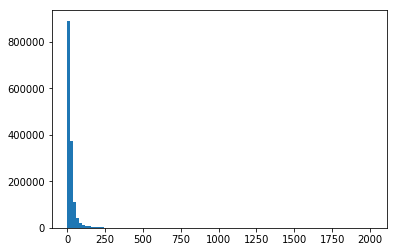

In [12]:
#defite target and remove it from train data

y_target = train.price
train.drop(['price'], axis=1, inplace=True)

plt.hist(y_target, bins=100)
plt.show()

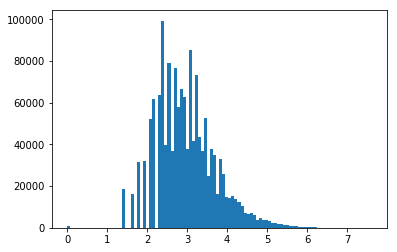

In [13]:
y_target_log = np.log1p(y_target)

plt.hist(y_target_log, bins=100)
plt.show()

# Preprocess categorical features

In [14]:
# create 3 categorical variables from category_name

def category_split(text):
    if text == 'missing':
        return ("missing", "missing", "missing")
    else:
        text_split = text.split("/")
        return text_split

train['category'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].progress_apply(category_split))
test['category'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].progress_apply(category_split))

HBox(children=(IntProgress(value=0, max=693359), HTML(value='')))

In [15]:
train.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,category,sub_cat1,sub_cat2
train_id,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!",Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,1,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


# Preprocess text features

In [5]:
negatives = {
    "didn't": "didn_`_t",
    "couldn't": "couldn_`_t",
    "don't": "don_`_t",
    "wouldn't": "wouldn_`_t",
    "doesn't": "doesn_`_t",
    "wasn't": "wasn_`_t",
    "weren't": "weren_`_t",
    "shouldn't":"shouldn_`_t",
    "isn't": "isn_`_t",
    "aren't": "aren_`_t",
}

regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')

def tokenize_text(text, treshold=2):
    text = regex.sub(" ", text.lower()) # remove punctuation
    #text = text.replace('<br />', ' ')
    text = ' '.join(tweet_tokenizer.tokenize(text))
    for k, v in negatives.items():
        text = text.lower().replace(k, v)
    return [i for i in word_tokenize(text) if i not in stop and len(i) > treshold]

def data_apply_tokenize_text(data):
    return data.apply(tokenize_text)

def data_apply_len(data):
    return data.apply(len)

In [18]:
train['desc_tokens'] = parallelize_apply(train.item_description, data_apply_tokenize_text)
train['name_tokens'] = parallelize_apply(train.name, data_apply_tokenize_text)
train['word_count_desc'] = train.desc_tokens.progress_apply(len)
train['word_count_name'] = train.name_tokens.progress_apply(len)
train.head()

HBox(children=(IntProgress(value=0, max=1482531), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1482531), HTML(value='')))

,name,item_condition_id,category_name,brand_name,shipping,item_description,category,sub_cat1,sub_cat2,desc_tokens,name_tokens,word_count_desc,word_count_name
train_id,,,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,1,No description yet,Men,Tops,T-shirts,"[description, yet]","[mlb, cincinnati, reds, shirt, size]",2,5
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.,Electronics,Computers & Tablets,Components & Parts,"[keyboard, great, condition, works, like, came, box, ports, tested, work, perfectly, lights, customizable, via, razer, synapse, app]","[razer, blackwidow, chroma, keyboard]",17,4
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!",Women,Tops & Blouses,Blouse,"[adorable, top, hint, lace, key, hole, back, pale, pink, also, available, white]","[ava, viv, blouse]",12,3
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,1,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage,Home,Home Décor,Home Décor Accents,"[new, tags, leather, horses, retail, stand, foot, high, sold, pair, questions, please, ask, free, shipping, got, storage]","[leather, horse, statues]",17,3
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,"[complete, certificate, authenticity]","[gold, plated, rose]",3,3


In [19]:
test['desc_tokens'] = parallelize_apply(test.item_description, data_apply_tokenize_text)
test['name_tokens'] = parallelize_apply(test.name, data_apply_tokenize_text)
test['word_count_desc'] = test.desc_tokens.progress_apply(len)
test['word_count_name'] = test.name_tokens.progress_apply(len)
test.head()

HBox(children=(IntProgress(value=0, max=693359), HTML(value='')))

HBox(children=(IntProgress(value=0, max=693359), HTML(value='')))

,name,item_condition_id,category_name,brand_name,shipping,item_description,category,sub_cat1,sub_cat2,desc_tokens,name_tokens,word_count_desc,word_count_name
test_id,,,,,,,,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7,Women,Jewelry,Rings,[size],"[breast, cancer, fight, like, girl, ring]",1,6
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined with bubble wrap for protection Self Sealing (peel-and-seal), adhesive keeps contents secure and tamper proof Durable and lightweight Kraft material helps save on postage Approved by UPS, FedEx, and USPS.",Other,Office supplies,Shipping Supplies,"[pcs, new, kraft, bubble, mailers, lined, bubble, wrap, protection, self, sealing, peel, seal, adhesive, keeps, contents, secure, tamper, proof, durable, lightweight, kraft, material, helps, save, postage, approved, ups, fedex, usps]","[pcs, new, kraft, bubble, mailers]",30,5
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coach outlet.,Vintage & Collectibles,Bags and Purses,Handbag,"[brand, new, coach, bag, bought, coach, outlet]","[coach, bag]",7,2
3,Floral Kimono,2,Women/Sweaters/Cardigan,missing,0,-floral kimono -never worn -lightweight and perfect for hot weather,Women,Sweaters,Cardigan,"[floral, kimono, never, worn, lightweight, perfect, hot, weather]","[floral, kimono]",8,2
4,Life after Death,3,Other/Books/Religion & Spirituality,missing,1,"Rediscovering life after the loss of a loved one by Tony Cooke. Paperback in good condition 2003. ❤ ❤ Bundle and save! ❤ ❤ Book, death, grief, bereavement SHLF.SW.5.15",Other,Books,Religion & Spirituality,"[rediscovering, life, loss, loved, one, tony, cooke, paperback, good, condition, bundle, save, book, death, grief, bereavement, shlf]","[life, death]",17,2


## WordClouds and popular tokens

In [20]:
# group the tokens by category and display the top 10 most frequent tokens
def keywords(category, data=train, number=10):
    alltokens = [item for tokens in data[data['category'] == category]['desc_tokens'].values for item in tokens]
    return Counter(alltokens).most_common(number)

def keywords_all(data=train):
    alltokens = [item for tokens in data['desc_tokens'].values for item in tokens]
    return Counter(alltokens)

for category in set(train['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))

category : missing
top 10 keywords: [('size', 1531), ('new', 1528), ('condition', 991), ('brand', 898), ('used', 812), ('worn', 735), ('never', 704), ('free', 704), ('description', 643), ('yet', 636)]
category : Electronics
top 10 keywords: [('iphone', 55371), ('new', 46141), ('case', 39843), ('brand', 26096), ('shipping', 25914), ('plus', 25006), ('free', 24486), ('phone', 23816), ('condition', 21546), ('used', 19490)]
category : Handmade
top 10 keywords: [('new', 8932), ('size', 7614), ('free', 7030), ('shipping', 6620), ('please', 5154), ('one', 4807), ('brand', 4759), ('black', 4088), ('price', 3828), ('stickers', 3805)]
category : Home
top 10 keywords: [('new', 25509), ('brand', 13540), ('shipping', 11389), ('free', 10189), ('used', 9901), ('dunn', 9389), ('rae', 9381), ('please', 8609), ('items', 7401), ('great', 6739)]
category : Beauty
top 10 keywords: [('new', 108653), ('brand', 63883), ('used', 57265), ('free', 49557), ('shipping', 47116), ('never', 35410), ('color', 32619), 

In [21]:
general_categories = set(train['category'])
category_description = {category:keywords(category, number=100) for category in general_categories}
category_description.keys()

dict_keys(['missing', 'Beauty', 'Other', 'Electronics', 'Men', 'Handmade', 'Women', 'Vintage & Collectibles', 'Kids', 'Sports & Outdoors', 'Home'])

Text(0.5,1,'Electronic Top 100')

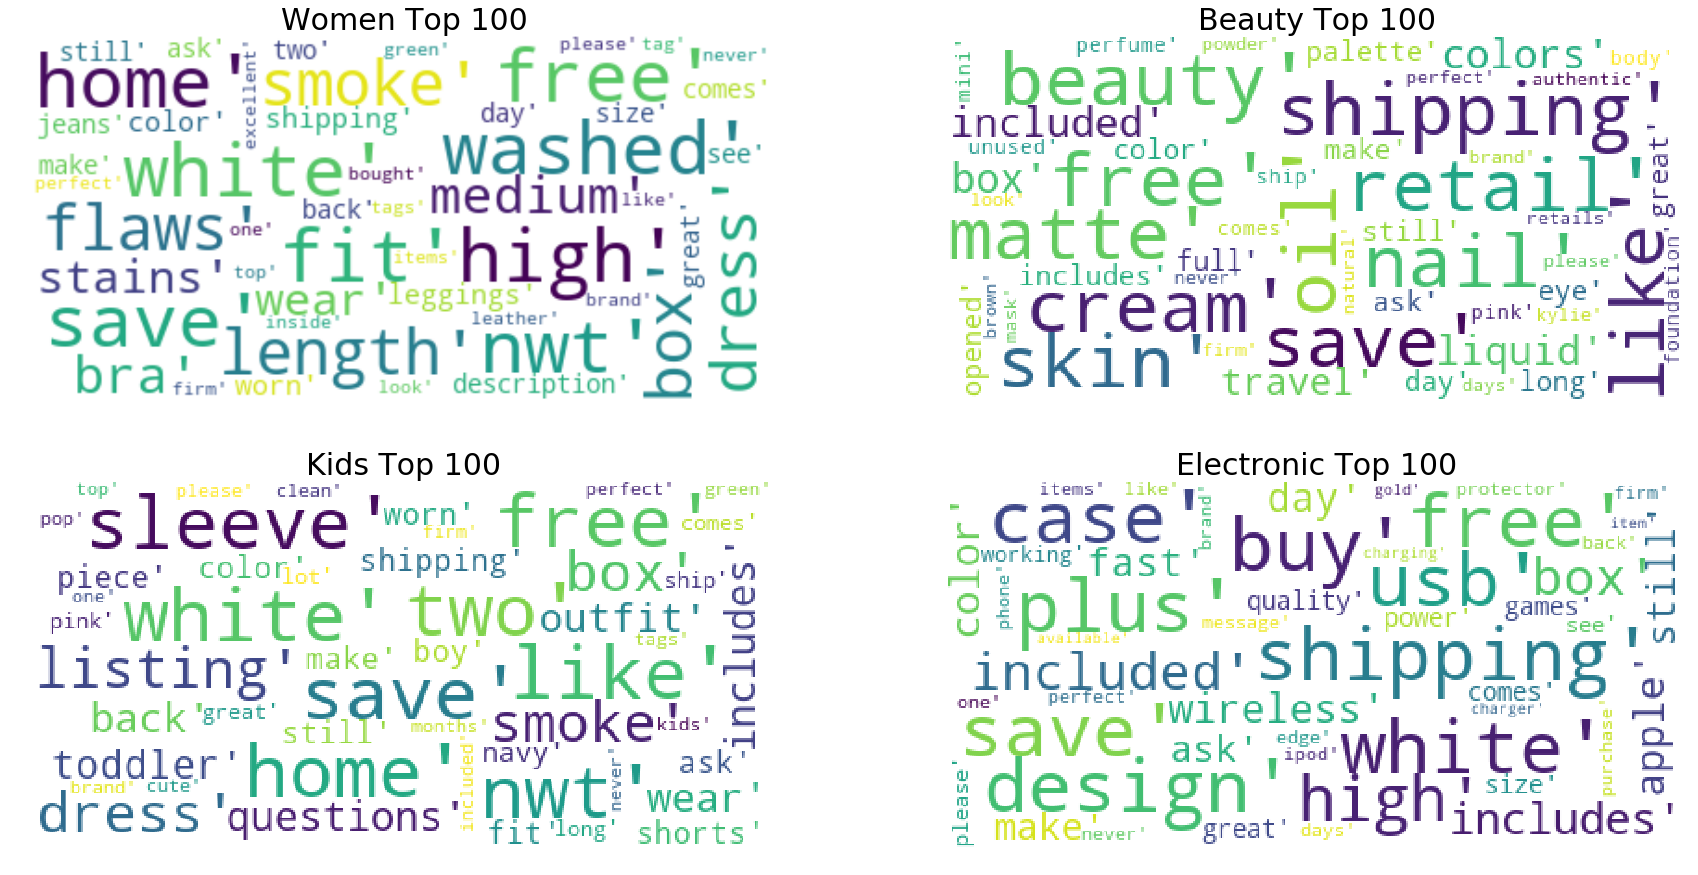

In [22]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                     ).generate(str(tup))
    return wordcloud

fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(category_description['Women']), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(category_description['Beauty']))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(category_description['Kids']))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(category_description['Electronics']))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

In [23]:
#save data after tokenization

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump((train, test), f, pickle.HIGHEST_PROTOCOL)

In [7]:
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    train, test = pickle.load(f)

## tf-idf

In [21]:
train['is_train'] = 1
test['is_train'] = 0

all_data = pd.concat([train, test])

sample_size = 100000
data_sample = all_data.sample(n=sample_size)

all_data.shape, data_sample.shape

((2175890, 14), (100000, 14))

In [25]:
# count words in all items
all_words = keywords_all(all_data)

In [26]:
print('in all data, count of words =', sum(all_words.values()))

in all data, count of words = 35077326


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TBD fit min_df and max_features in feature

vectorizer = TfidfVectorizer(min_df=0.0005,
                             max_df=0.95,
                             max_features=200000,
                             tokenizer=tokenize_text,
                             ngram_range=(1, 2))

vectorize_sample = vectorizer.fit_transform(list(data_sample['item_description']))
vectorize_sample

<100000x5124 sparse matrix of type '<class 'numpy.float64'>'
	with 1593103 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Standardize the feature matrix
vectorize_sample_scale = StandardScaler().fit_transform(vectorize_sample.toarray())

In [74]:
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=vectorize_sample_scale.shape[1]-1)
vectorize_sample_tsvd = tsvd.fit(vectorize_sample_scale)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [85]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0

    # Set initial number of features
    n_components = 0

    # For the explained variance of each feature:
    for explained_variance in var_ratio:

        # Add the explained variance to the total
        total_variance += explained_variance

        # Add one to the number of components
        n_components += 1

        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break

    # Return the number of components
    return n_components

n_comp = select_n_components(tsvd_var_ratios, 0.8)

In [24]:
n_comp = 200

svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vectorize_sample_scale)

In [ ]:
svd_tfidf.shape

(100000, 200)

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE
#%load_ext wurlitzer

tsne_model = TSNE(n_jobs=4, n_components=2, verbose=1, random_state=42)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.867s...
[t-SNE] Computed neighbors for 100000 samples in 3105.970s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

In [ ]:
output_notebook()
plot_tfidf = bp.figure(plot_width=1000, plot_height=1000,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

data_sample.reset_index(inplace=True, drop=True)

tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
#tfidf_df['description'] = data_sample['item_description']
tfidf_df['tokens'] = data_sample['desc_tokens']
tfidf_df['category'] = data_sample['category']


plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

In [ ]:
all_description = np.append(train['item_description'].values, test['item_description'].values)
all_names = np.append(train['name'].values, test['name'].values)

vz = vectorizer.fit_transform(list(all_desc))

In [14]:
#define data_train and data_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y_target_log, 
                                                    test_size=0.034, 
                                                    random_state=42,
                                                   stratify='category_name')

X_train.shape, len(y_train), X_test.shape, len(y_test)

((1432128, 9), 1432128, (50407, 9), 50407)

# Baseline